In [12]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,regularizers,initializers
from tensorflow.keras.layers import Dropout,Dense,Activation,BatchNormalization
import matplotlib.pyplot as plt

In [2]:
#funkcja do wywoływania sieci neuronowych

#funkcja wywolujaca funkcje aktywacji

def Activ_func(model,activation):
    if activation=='prelu':
        model.add(keras.layers.PReLU())
    else:
        model.add(Activation(activation))

#tworzenie modelu
def create_model(n=2,nu=[100,40],debug=False,activation='relu', 
                 kernel_initializer='lecun_normal',inputShape=10,dropout_rate=0,dropout=Dropout,
                 dropout_all_layers=False,optimizer='SGD',regu=0,num_classes=2,
                 batch_normalization=False,*args,**kwargs): 
    model=Sequential()
    
    #pierwsza warstwa
    model.add(Dense(nu[0],kernel_initializer=kernel_initializer,kernel_regularizer=regularizers.l2(regu),input_shape=(inputShape,)))
    Activ_func(model,activation)
    
    #dodajemy dropout na pierwszej wartstwie
    if dropout_rate>=0.01:
        model.add(dropout(dropout_rate))
        
    #pozostale warstwy
    for i in range(1,n):
        model.add(Dense(nu[i],kernel_initializer=kernel_initializer))
        Activ_func(model,activation)
        
        #batch_normalization dla pozostałych warstw, input wystandaryzowany poza funkcją
        if batch_normalization:
            model.add(BatchNormalization())
            
        #dropout
        if dropout_rate>=0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=[tf.keras.metrics.Precision()]) 
    return model

#funkcja do wywolywania i trenowania modelu

def net(X_train,X_valid,features,target,epochs=50,batchSize=50,debug=False,patience=5,*args,**kwargs):
    model=create_model(debug=debug,inputShape=len(features),*args,**kwargs)
    history=model.fit(X_train[features],pd.get_dummies(X_train[target]),batch_size=batchSize,epochs=epochs,verbose=debug,validation_data=(X_valid[features],pd.get_dummies(X_valid[target])),callbacks=tf.keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True))
    preds=model.predict(X_valid[features])[:,1]
    prec=average_precision_score(X_valid[target],preds)
    return prec, preds, history.history

In [3]:
df=pd.read_excel("dumm_credit_card_data.xlsx",index_col="ID")

In [4]:
features=pd.concat([df.loc[:,:"PAY_AMT6"],df.loc[:,"SEX_2":]],axis=1).columns.tolist()

In [9]:
#standaryzacja

df.loc[:,'LIMIT_BAL':'PAY_AMT6']=df.loc[:,'LIMIT_BAL':'PAY_AMT6'].apply(lambda x: (x-np.mean(x))/np.std(x))

In [14]:
#wrapper do walidacji krzyzowej dla sieci neuronowych

def CV_NN(df=df,n_splits=5,random_state=111,features=features,*args,**kwargs):
    test_precisions=[]
    probs=[]
    indices=[]
    skf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state)
    for train,test in skf.split(df[features],df.y):
        prec, preds, history=net(df.iloc[train],df.iloc[test],features,'y',*args,**kwargs)
        probs.append(preds.tolist().copy())
        indices.append(test.tolist())
        test_precisions.append(prec)
    return test_precisions, probs, indices, history

SGD 0.9078174220787643
RMSProp 0.9082989470953782
Adadelta 0.8597762797917918
Adagrad 0.8980302091692887
Adam 0.910373228007581
Adamax 0.9093598415375654
Nadam 0.9099756843722158


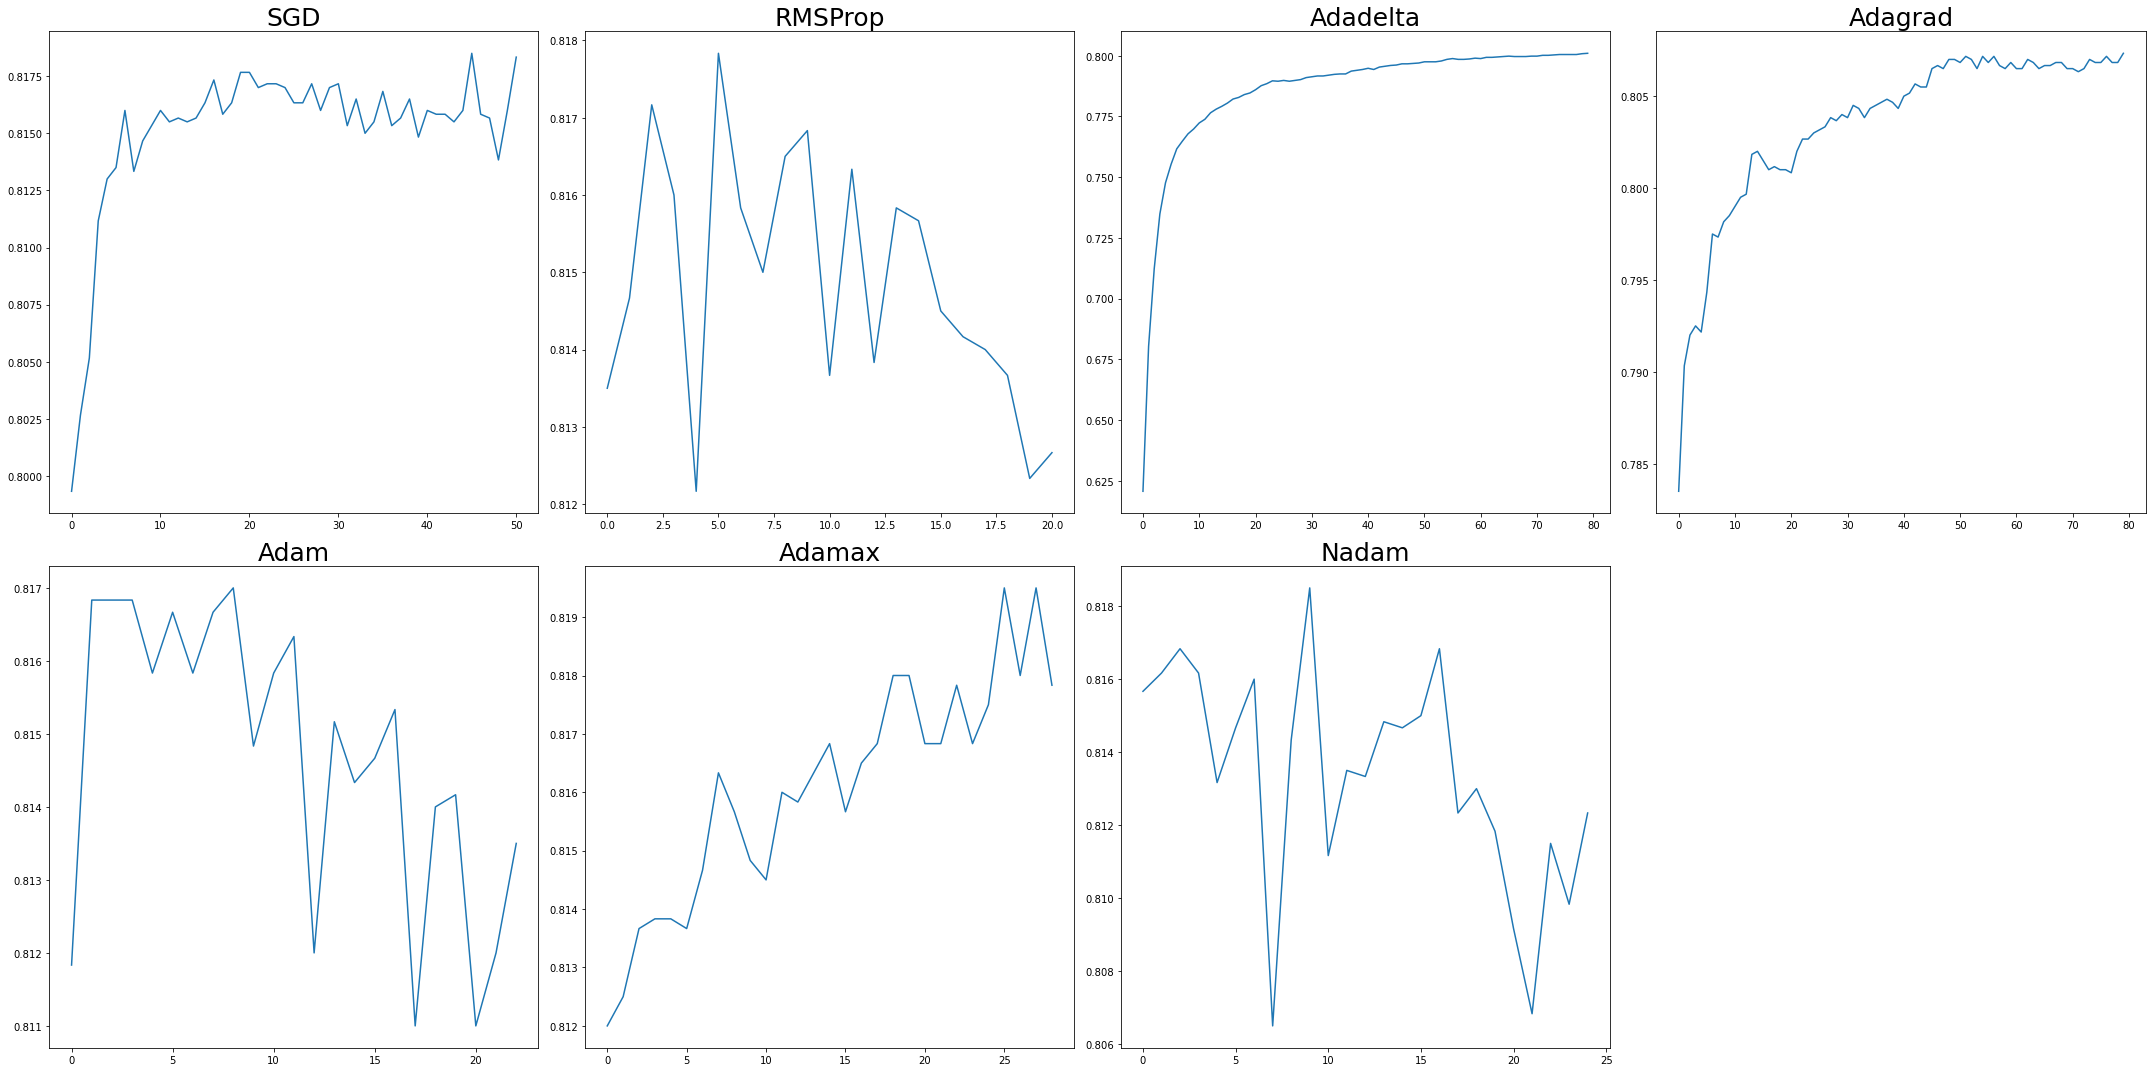

In [15]:
# sprawdzam rozne optymalizatory

fig,ax=plt.subplots(2,4,figsize=(30,15))
ax=ax.flatten()
fig.delaxes(ax[-1])
for i,opt in enumerate(['SGD','RMSProp','Adadelta','Adagrad','Adam','Adamax','Nadam']):
    test_precisions, probs, indices, history=CV_NN(patience=15,epochs=80,optimizer=opt)
    print(opt,np.mean(test_precisions))
    ax[i].plot(history[list(history.keys())[-1]])
    ax[i].set_title(opt,size=25)
fig.tight_layout()
plt.show()

SGD 0.9074096192322537
RMSProp 0.9090042561493107
Adadelta 0.8717175020042589
Adagrad 0.9022819965262091
Adam 0.9098757472826895
Adamax 0.9086095697000495
Nadam 0.9088204644991459


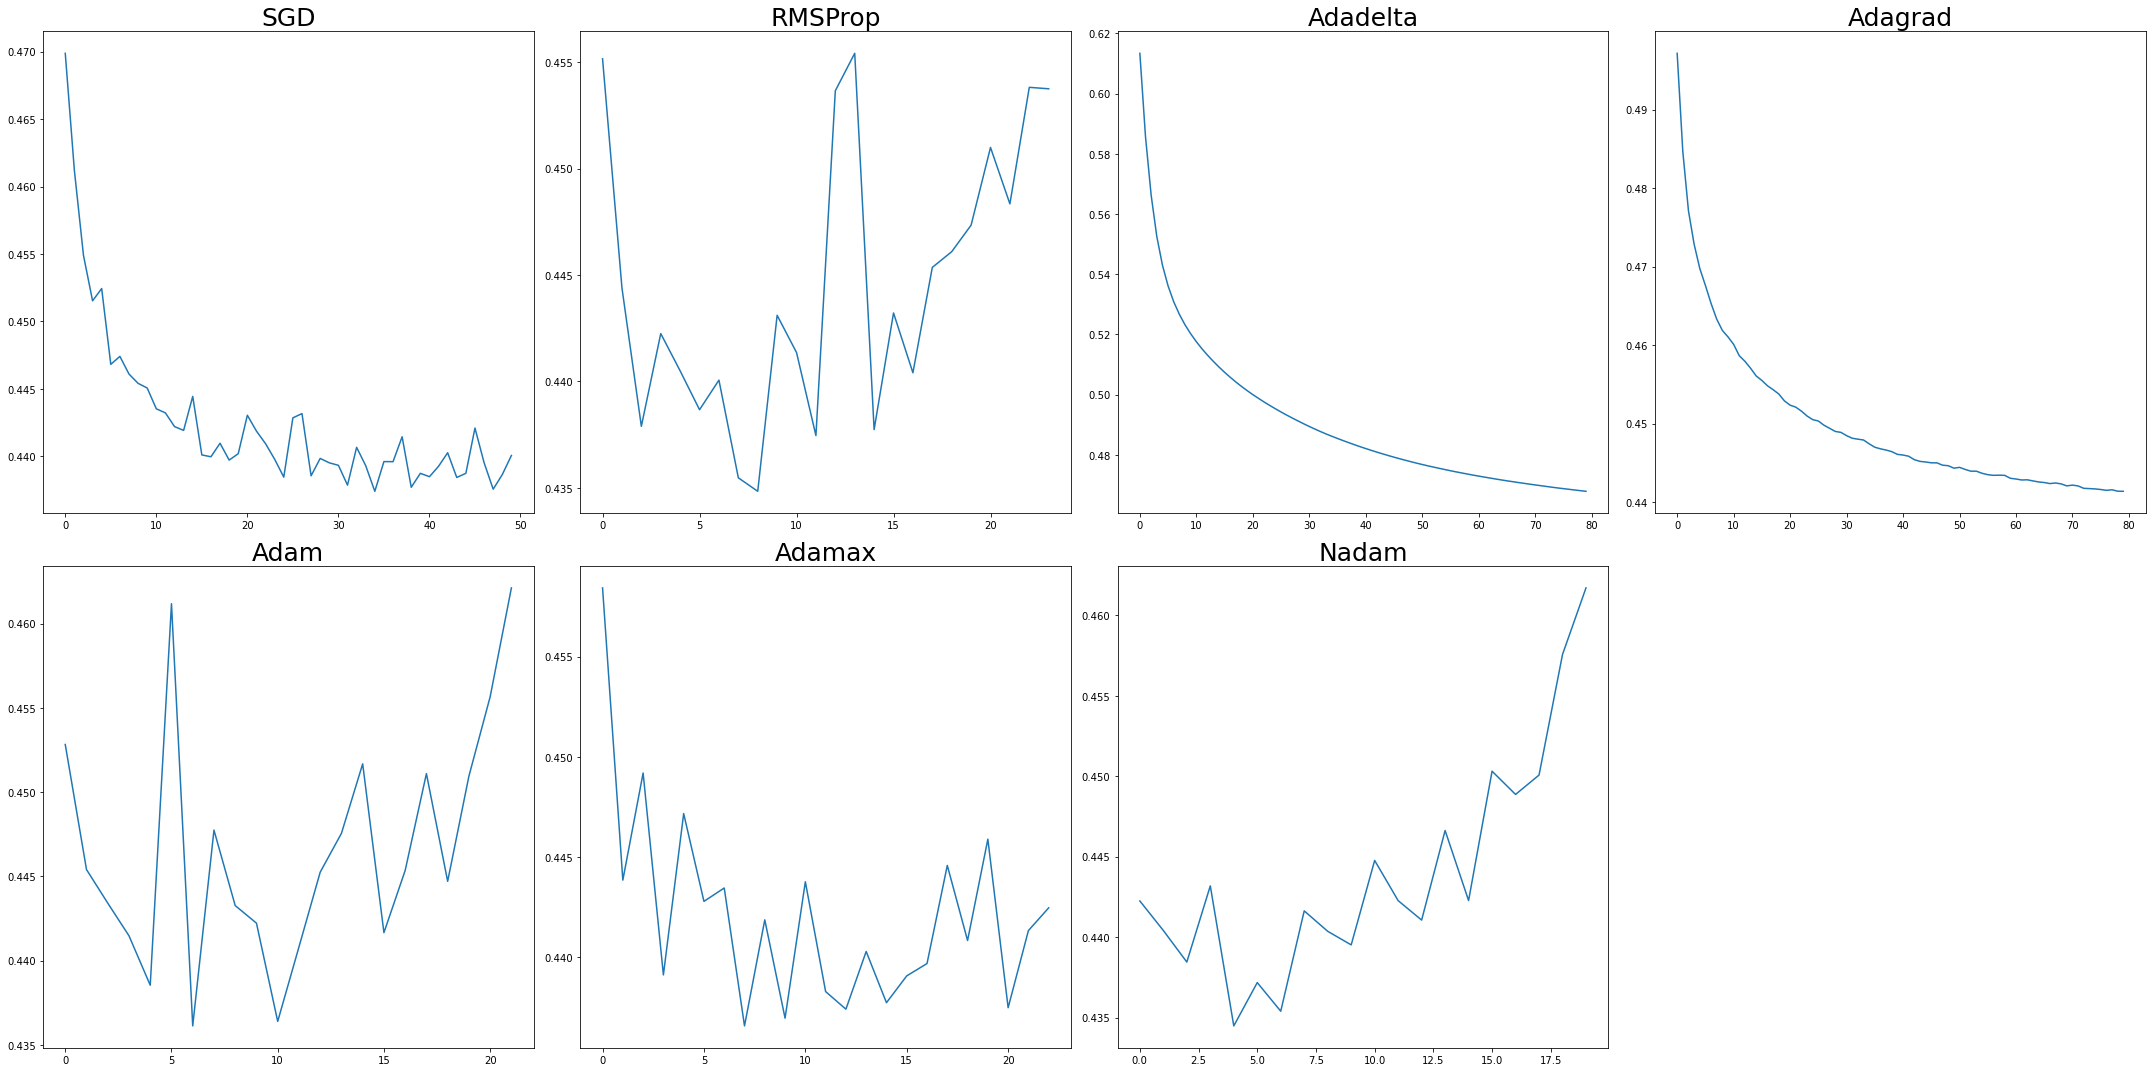

In [17]:
#siec o wiekszej liczbie neuronow

fig,ax=plt.subplots(2,4,figsize=(30,15))
ax=ax.flatten()
fig.delaxes(ax[-1])
for i,opt in enumerate(['SGD','RMSProp','Adadelta','Adagrad','Adam','Adamax','Nadam']):
    test_precisions, probs, indices, history=CV_NN(nu=[200,80],patience=15,epochs=80,optimizer=opt)
    print(opt,np.mean(test_precisions))
    ax[i].plot(history['val_loss'])
    ax[i].set_title(opt,size=25)
fig.tight_layout()
plt.show()

SGD 0.908016383969682
RMSProp 0.9091710918563047
Adadelta 0.8721725464785749
Adagrad 0.903617542246484
Adam 0.9105566699357313
Adamax 0.9087939635656669
Nadam 0.9105139195803187


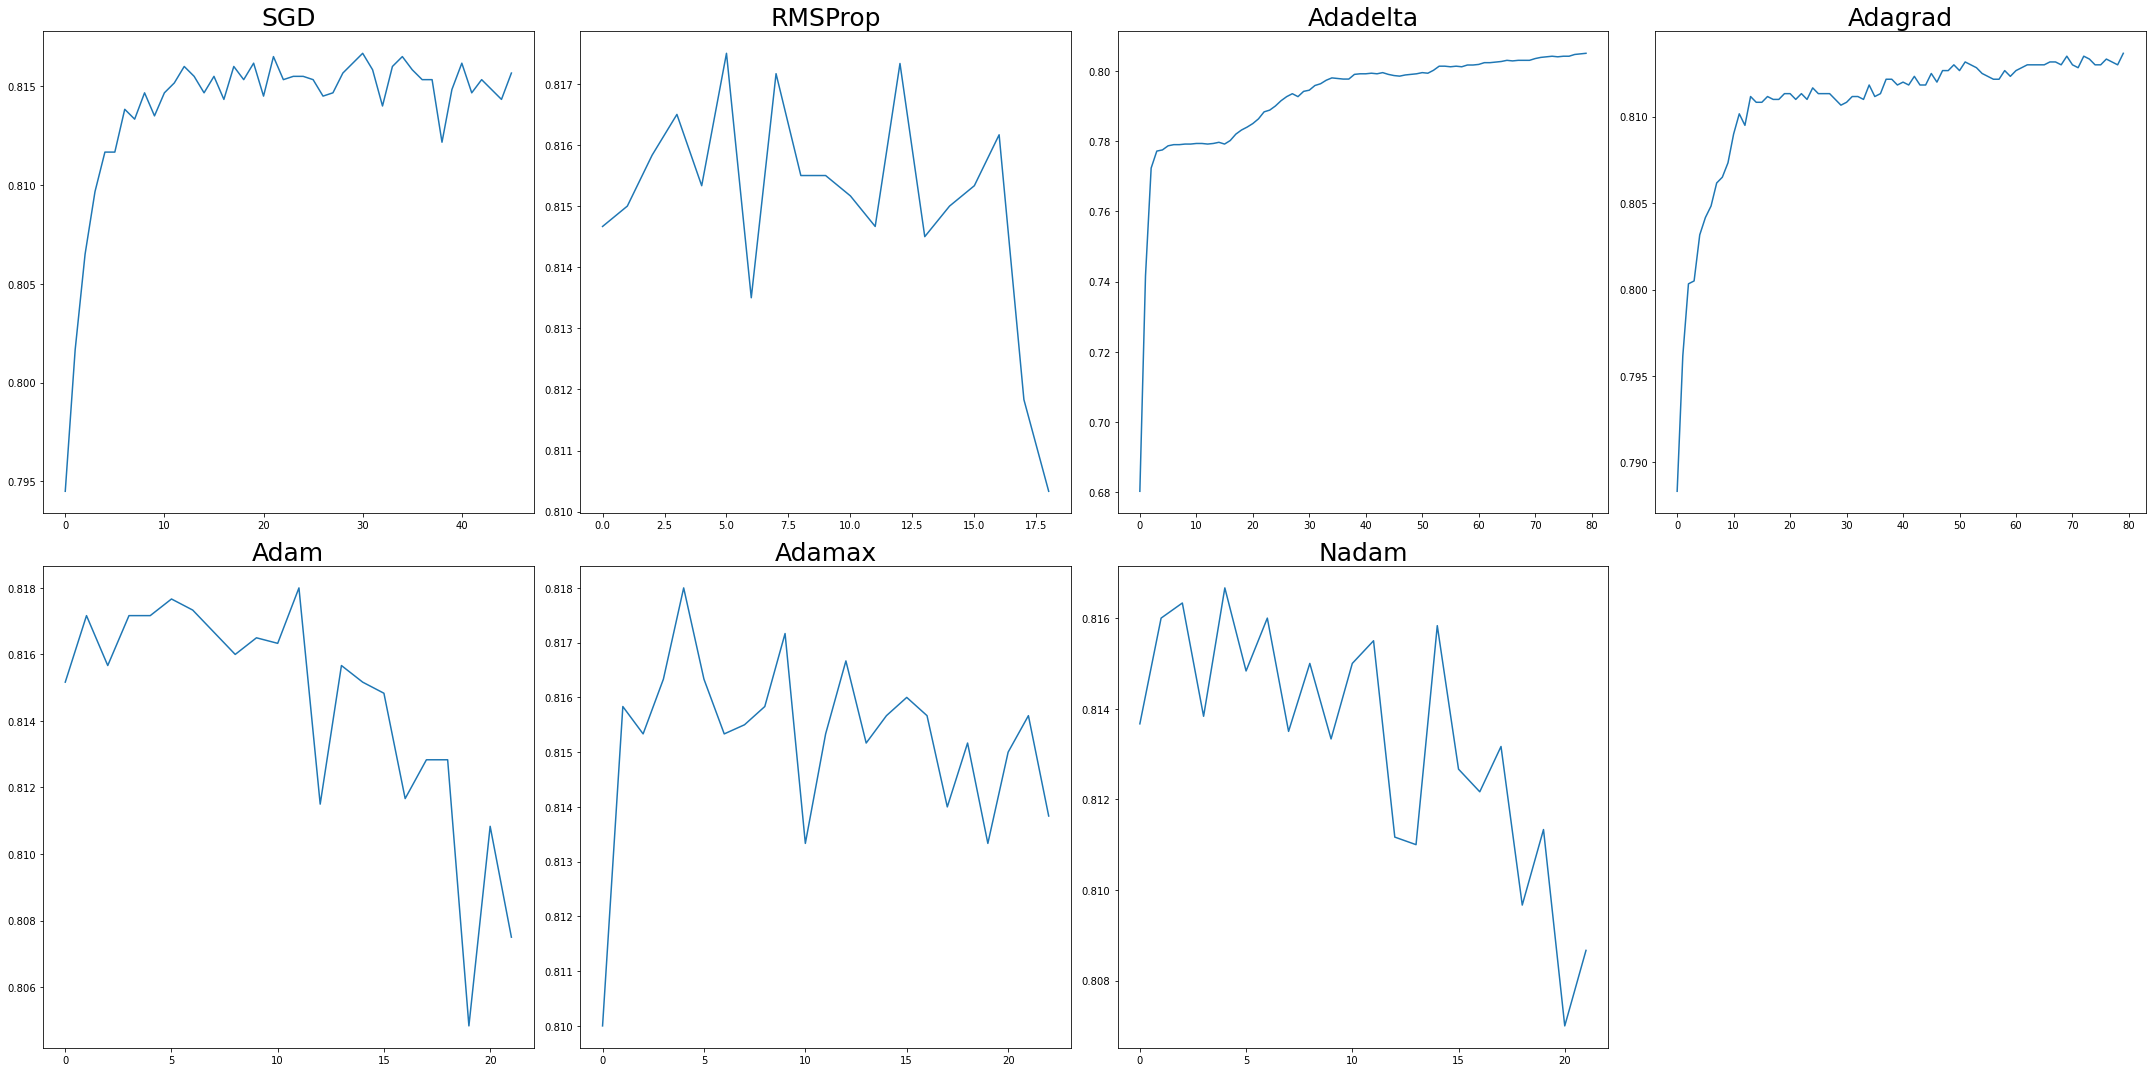

In [18]:
#siec trzywarstwowa

fig,ax=plt.subplots(2,4,figsize=(30,15))
ax=ax.flatten()
fig.delaxes(ax[-1])
for i,opt in enumerate(['SGD','RMSProp','Adadelta','Adagrad','Adam','Adamax','Nadam']):
    test_precisions, probs, indices, history=CV_NN(n=3,nu=[200,80,20],patience=15,epochs=80,optimizer=opt)
    print(opt,np.mean(test_precisions))
    ax[i].plot(history[list(history.keys())[-1]])
    ax[i].set_title(opt,size=25)
fig.tight_layout()
plt.show()

Adam 50 0.9103860700107347
Adam 100 0.909937530442081
Adam 200 0.9092689011064825
Adam 500 0.9094884689467901
Nadam 50 0.9106531539158655
Nadam 100 0.9093865108088917
Nadam 200 0.9093364948141428
Nadam 500 0.9095356138121933


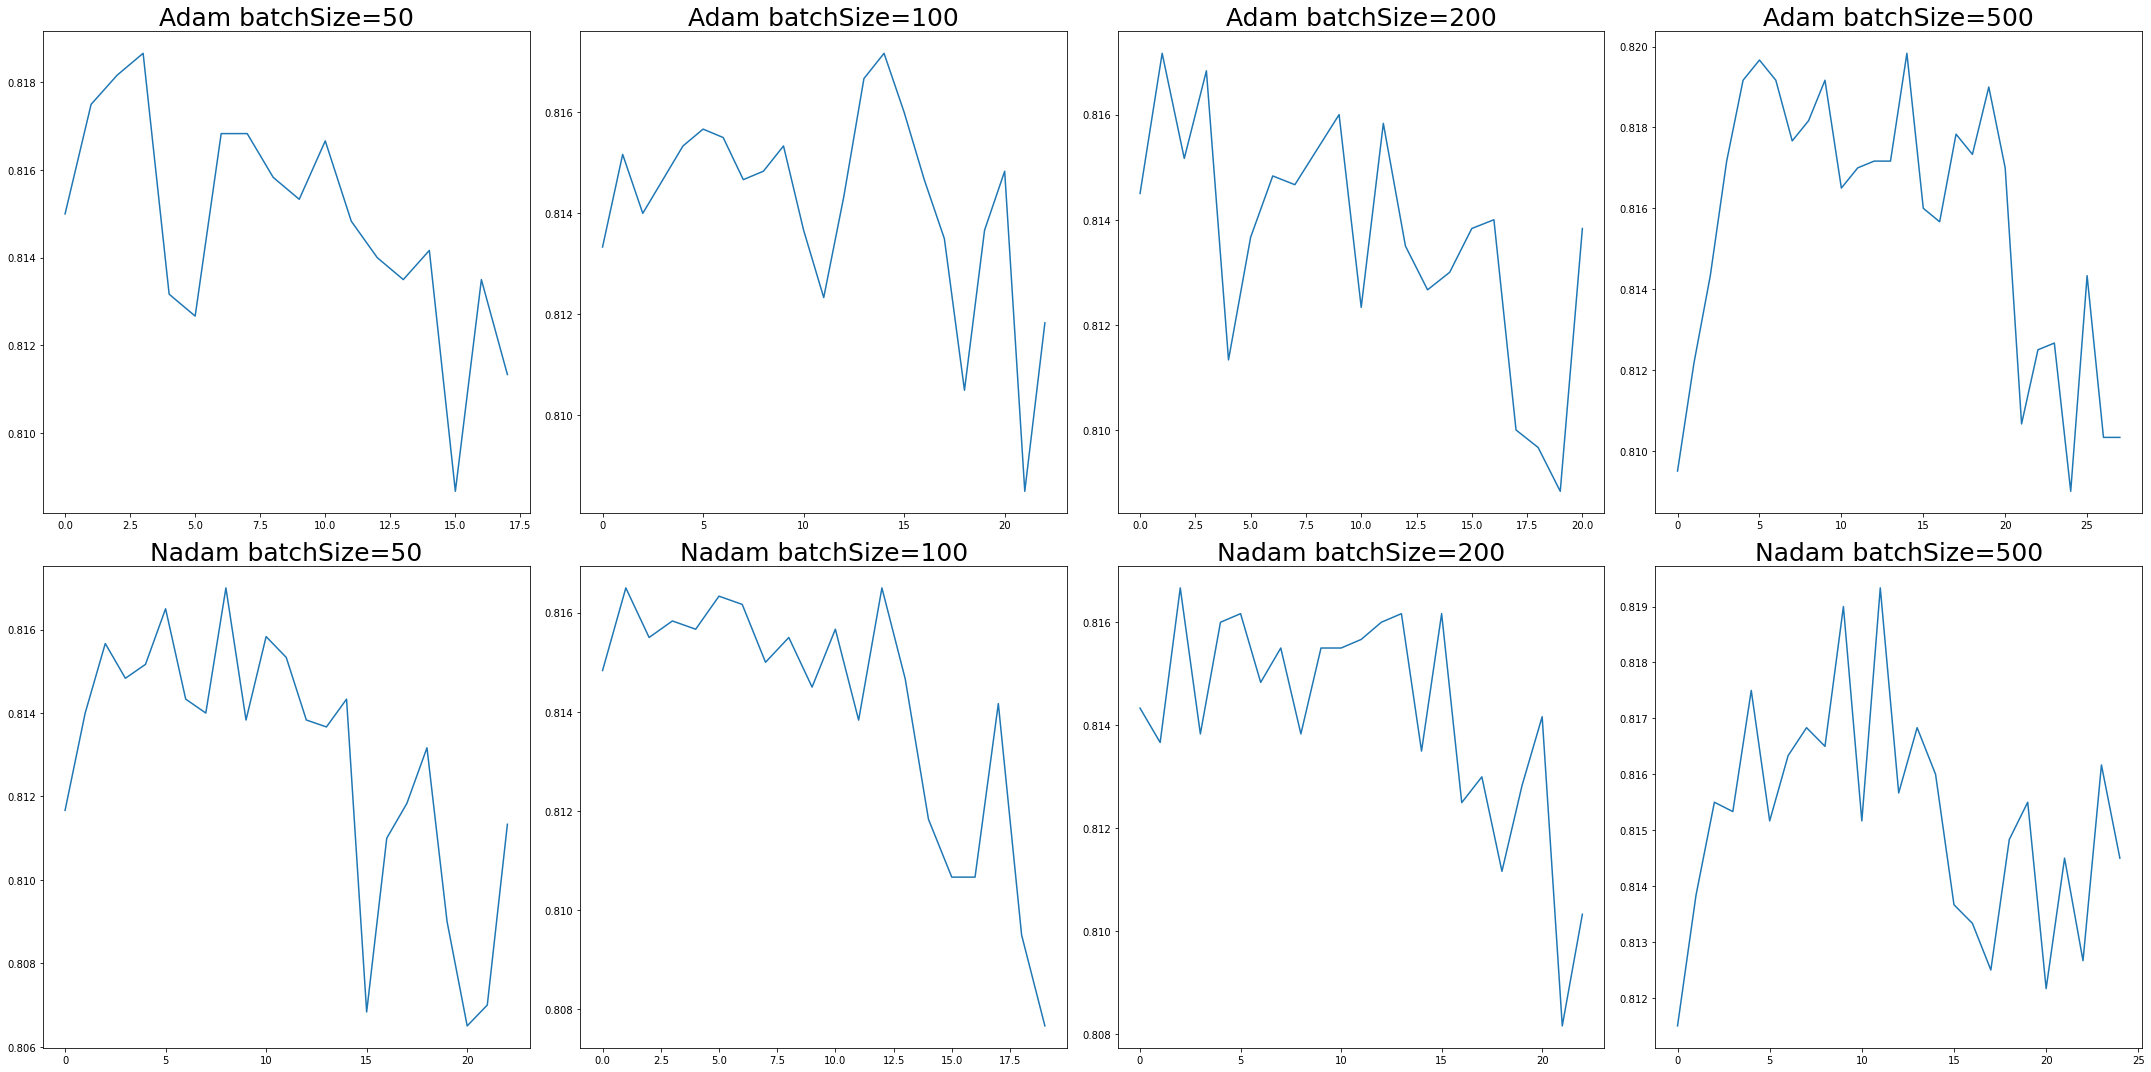

In [19]:
#najlepsze wyniki dla optymalizatorow adam i nadam
#sprawdzam batchSize

fig,ax=plt.subplots(2,4,figsize=(30,15))
for i,opt in enumerate(['Adam','Nadam']):
    for j, batchSize in enumerate([50,100,200,500]):
        test_precisions, probs, indices, history=CV_NN(n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=batchSize,optimizer=opt)
        print(opt,batchSize,np.mean(test_precisions))
        ax[i,j].plot(history[list(history.keys())[-1]])
        ax[i,j].set_title(opt+' batchSize='+str(batchSize),size=25)
fig.tight_layout()
plt.show()

sigmoid 0.9113523361024317
swish 0.9113980538286125
relu 0.9100620562774482
prelu 0.9091480500362866
tanh 0.910534719624432
linear 0.8765571472609223
selu 0.9101243962788835


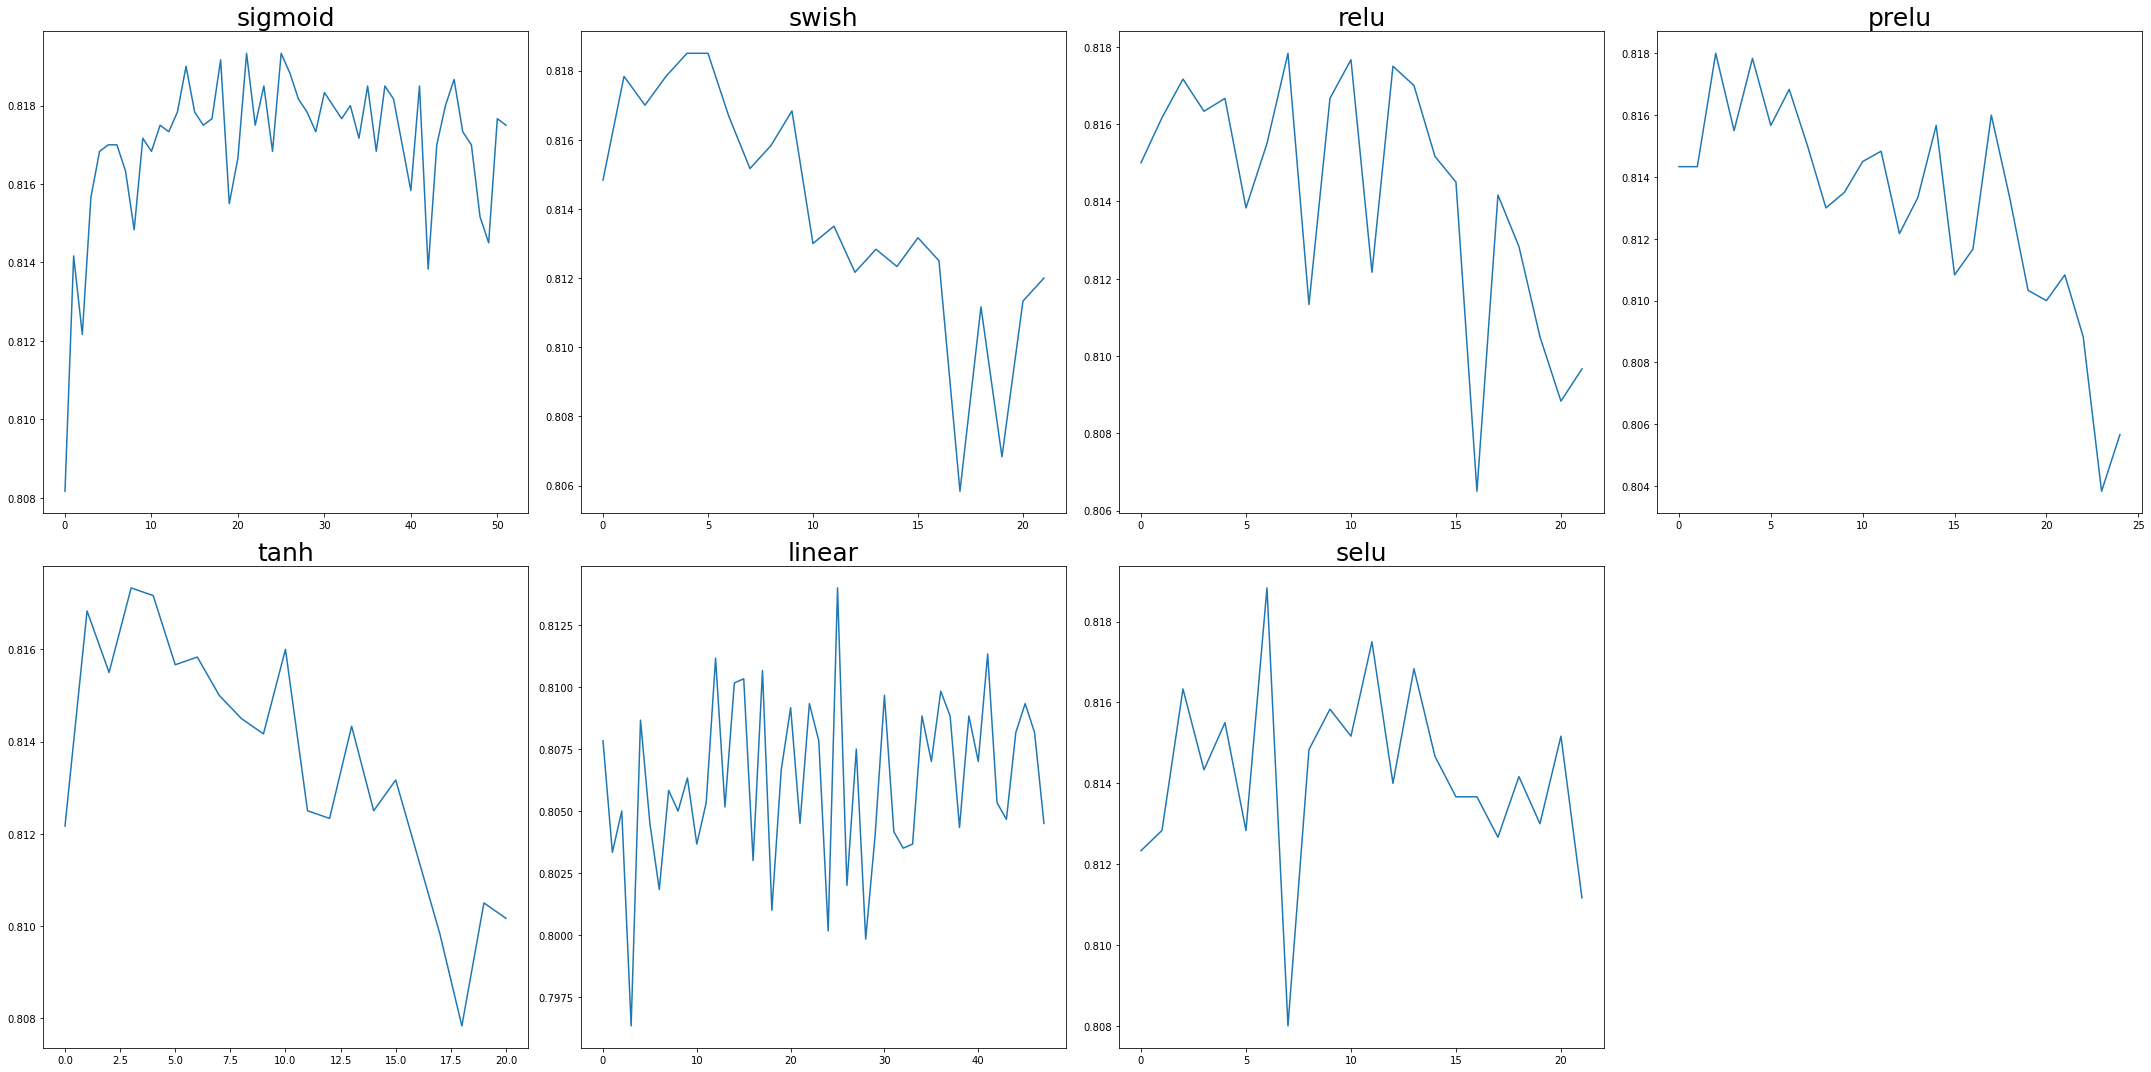

In [20]:
#funkcje aktywacji dla najlepszego modelu, optymalizator Nadam i batchSize 50

fig,ax=plt.subplots(2,4,figsize=(30,15))
ax=ax.flatten()
fig.delaxes(ax[-1])
for i,act in enumerate(['sigmoid','swish','relu','prelu','tanh','linear','selu']):
        test_precisions, probs, indices, history=CV_NN(n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation=act)
        print(act,np.mean(test_precisions))
        ax[i].plot(history[list(history.keys())[-1]])
        ax[i].set_title(act,size=25)
fig.tight_layout()
plt.show()

In [21]:
#najlepszy wynik dla funkcji aktywacji swish, sprawdzam dropout

for dropout_rate in [0,0.2,0.4,0.5,0.6,0.8]:
    test_precisions, probs, indices, history=CV_NN(n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=dropout_rate)
    print(dropout_rate,np.mean(test_precisions))

0 0.9107717528039515
0.2 0.9114609647033071
0.4 0.9124266840965263
0.5 0.9124198874246762
0.6 0.9122120864489827
0.8 0.9119475723228782


In [22]:
for dropout_rate in [0,0.2,0.4,0.5,0.6,0.8]:
    test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=dropout_rate)
    print(dropout_rate,np.mean(test_precisions))


0 0.9121672014498046
0.2 0.9128421221292438
0.4 0.9132790818979497
0.5 0.9125099572213748
0.6 0.912107547982558
0.8 0.9084264140029255


In [23]:
#sprawdzam regularyzacje 

for regu in [0,0.001,0.005,0.01,0.05,0.1,1]:
    test_precisions, probs, indices, history=CV_NN(n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',regu=regu)
    print(regu,np.mean(test_precisions))

0 0.9109706477302199
0.001 0.9113011320346743
0.005 0.9110866623156808
0.01 0.9093152045799385
0.05 0.9043546564511644
0.1 0.9020754159513219
1 0.8982025193094911


In [24]:
#najlepszy wynik dla dropoutu 0.4 dla wszystkich warstw
#sprawdzam normalizacje pomiedzy warstwami

test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=0.4,batch_normalization=True)
print(np.mean(test_precisions))

0.913018207868649


In [25]:
#brak poprawy, sprawdzam 4 warstwy

test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,n=4,nu=[200,80,20,10],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=0.4)
print(np.mean(test_precisions))

0.9127958125894404


In [26]:
#brak poprawy, sprawdzam wieksza liczbe neuronow

test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,n=3,nu=[400,160,40],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=0.4)
print(np.mean(test_precisions))

0.9121727839638887


In [27]:
#brak poprawy
#warto sprawdzic tez random search

results=[]
for i in range(50):
    parameters={
                'activation':np.random.choice(['sigmoid','swish','tanh','selu','relu']),
                'optimizer':np.random.choice(['Adam','Nadam']),
                'batchSize':np.random.randint(50,101),
                'dropout_rate':np.random.uniform(0,0.6),
                'dropout_all_layers':np.random.choice([True,False]),
                'n':np.random.choice([2,3]),
                'nu':[int(np.random.uniform(100,400)),int(np.random.uniform(40,160))]}
    if parameters['n']==3:
        parameters['nu'].append(int(np.random.uniform(10,30)))
    test_precisions, probs, indices, history=CV_NN(patience=10,epochs=80,**parameters)
    prec=np.mean(test_precisions)
    results.append((prec,parameters.copy()))
    print(prec,parameters) 

0.9113595547881779 {'activation': 'tanh', 'optimizer': 'Adam', 'batchSize': 73, 'dropout_rate': 0.16764334852523488, 'dropout_all_layers': False, 'n': 2, 'nu': [117, 54]}
0.9114647390420766 {'activation': 'relu', 'optimizer': 'Adam', 'batchSize': 56, 'dropout_rate': 0.5562682579475284, 'dropout_all_layers': False, 'n': 2, 'nu': [273, 94]}
0.9116761175891103 {'activation': 'tanh', 'optimizer': 'Nadam', 'batchSize': 76, 'dropout_rate': 0.3033456253823905, 'dropout_all_layers': False, 'n': 3, 'nu': [236, 152, 21]}
0.9120213500586327 {'activation': 'sigmoid', 'optimizer': 'Nadam', 'batchSize': 52, 'dropout_rate': 0.2957696865073418, 'dropout_all_layers': True, 'n': 3, 'nu': [155, 98, 24]}
0.9125067936886578 {'activation': 'swish', 'optimizer': 'Adam', 'batchSize': 88, 'dropout_rate': 0.27699752365612246, 'dropout_all_layers': True, 'n': 3, 'nu': [362, 93, 20]}
0.9127949542823199 {'activation': 'relu', 'optimizer': 'Nadam', 'batchSize': 77, 'dropout_rate': 0.44390894030001116, 'dropout_all_

0.9108151577121847 {'activation': 'tanh', 'optimizer': 'Adam', 'batchSize': 89, 'dropout_rate': 0.5364367345823927, 'dropout_all_layers': False, 'n': 2, 'nu': [385, 85]}
0.9113733043466429 {'activation': 'tanh', 'optimizer': 'Nadam', 'batchSize': 70, 'dropout_rate': 0.15049686397310724, 'dropout_all_layers': True, 'n': 3, 'nu': [372, 120, 13]}


In [28]:
sorted(results,key=lambda x: x[0],reverse=True)

[(0.9127949542823199,
  {'activation': 'relu',
   'optimizer': 'Nadam',
   'batchSize': 77,
   'dropout_rate': 0.44390894030001116,
   'dropout_all_layers': True,
   'n': 3,
   'nu': [341, 126, 16]}),
 (0.9126779687232041,
  {'activation': 'swish',
   'optimizer': 'Nadam',
   'batchSize': 91,
   'dropout_rate': 0.28025414513591324,
   'dropout_all_layers': True,
   'n': 2,
   'nu': [169, 85]}),
 (0.9126517747193004,
  {'activation': 'swish',
   'optimizer': 'Nadam',
   'batchSize': 76,
   'dropout_rate': 0.3963956364107842,
   'dropout_all_layers': True,
   'n': 2,
   'nu': [334, 101]}),
 (0.9125138672746432,
  {'activation': 'swish',
   'optimizer': 'Adam',
   'batchSize': 78,
   'dropout_rate': 0.37701544493033323,
   'dropout_all_layers': True,
   'n': 3,
   'nu': [166, 77, 27]}),
 (0.9125067936886578,
  {'activation': 'swish',
   'optimizer': 'Adam',
   'batchSize': 88,
   'dropout_rate': 0.27699752365612246,
   'dropout_all_layers': True,
   'n': 3,
   'nu': [362, 93, 20]}),
 (0.9

In [32]:
#sprawdzam wynik najlepszego modelu z random search dla 4 warstw

test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,patience=10,epochs=80,activation='relu',optimizer='Nadam',batchSize=77,droput_rate=0.44,n=4,nu=[341,126,16,10])
print(np.mean(test_precisions))

0.9099381538646227


In [49]:
#brak poprawy, najlepszy model dla grid search

test_precisions, probs, indices, history=CV_NN(dropout_all_layers=True,n=3,nu=[200,80,20],patience=15,epochs=80,batchSize=50,optimizer='Nadam',activation='swish',dropout_rate=0.4)
precis=np.mean(test_precisions)
print(precis)

0.9130308992772124


In [50]:
def create_probs_series(probs,indices):
    probs=sum(probs,[])
    indices=sum(indices,[])
    probs=pd.Series(probs,index=indices).sort_index()
    probs.index=range(1,30001)
    return probs

In [51]:
probs=create_probs_series(probs,indices)

In [44]:
modelNN = {
    "nazwa":"Neural Networks",
    "opis":"Model sieci neuronowych, epochs=80, activation='swish', optimizer='Nadam', batchSize=50, dropout=0.4, n=3, nu=[200,80,20], dropout_all_layers=True",
    "specyfikacja":{'patience':15,'epochs':80, 'activation':'swish', 'optimizer':'Nadam',
                    'batchSize':50,'dropout_rate':0.4,'n':3,'nu':[200,80,20],'dropout_all_layers':True,'features':features,'df':df},     
    "precyzja":precis,
    "predykcje":probs.copy(),
    }

NameError: name 'precis' is not defined